# Importing Libraries

In [31]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler

In [32]:
import classes.file_loader as file_loader
import classes.linear_time_series as linear_time_series
import classes.tools as tools
import classes.gated_reccurent_unit as gated_reccurent_unit 

# Data Preprocessing

## Loading Files

In [33]:
file_path = "" # File is in the parent file
file_name = "Index.xlsx"

FileLoader = file_loader.FileLoader(file_path, file_name)

In [34]:
classic_sheet_name, precarity_sheet_name = "Classique","Précarité"

classic_raw_df, preacarity_raw_df = FileLoader.load_file(classic_sheet_name, precarity_sheet_name)

In [35]:
classic_raw_df

,Date,SPOT
0,2023-04-24,7.212716
1,2023-05-01,7.321166
2,2023-05-08,7.360211
3,2023-05-15,7.380000
4,2023-05-22,7.400000
...,...,...
85,2024-12-16,7.810000
86,2024-12-23,7.970000
87,2024-12-30,7.970000
88,2025-01-06,7.970000


In [36]:
preacarity_raw_df

,Date,SPOT
0,2023-04-24,7.296783
1,2023-05-01,7.460184
2,2023-05-08,7.465385
3,2023-05-15,7.465385
4,2023-05-22,7.473191
...,...,...
85,2024-12-16,9.720000
86,2024-12-23,9.820000
87,2024-12-30,9.820000
88,2025-01-06,10.030000


## Augmented dataframes

In [37]:
augmented_classic_df = FileLoader.interpolate_dataframe(classic_raw_df)
augmented_classic_df.to_csv("augmented_classic_df.csv", index=False)
augmented_classic_df

,Date,SPOT
0,2023-04-24,7.212716
1,2023-04-25,7.206350
2,2023-04-26,7.246352
3,2023-04-27,7.272463
4,2023-04-28,7.269450
...,...,...
446,2025-01-07,7.986361
447,2025-01-08,7.952876
448,2025-01-09,7.981298
449,2025-01-10,7.989128


In [38]:
augmented_precarity_df = FileLoader.interpolate_dataframe(preacarity_raw_df)
augmented_precarity_df.to_csv("augmented_precarity_df.csv", index=False)
augmented_precarity_df

,Date,SPOT
0,2023-04-24,7.296783
1,2023-04-25,7.294167
2,2023-04-26,7.310253
3,2023-04-27,7.333490
4,2023-04-28,7.464436
...,...,...
446,2025-01-07,9.983752
447,2025-01-08,10.329386
448,2025-01-09,10.079581
449,2025-01-10,10.407575


## Plotting the selected augmented dataframes 

We select one iteration of fir the classic and precarirty dataframe.

In [39]:
classic_df = pd.read_csv("selected_augmented_classic_df.csv")
precarity_df = pd.read_csv("selected_augmented_precarity_df.csv")

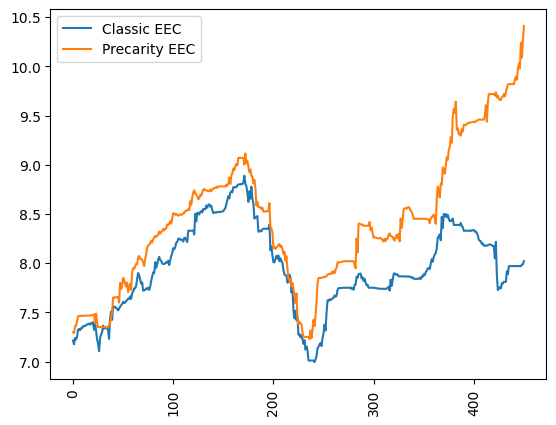

In [40]:
plt.figure()

plt.plot(classic_df["SPOT"], label = "Classic EEC")
plt.plot(precarity_df["SPOT"], label = "Precarity EEC")
plt.legend()
plt.xticks(rotation = 90)

plt.show()

Now we will separate data between data that will be used to train our models and the data which will be used to test our trading strategies.

From the Graph we can clearly see that the data is non stationnary. We will first differentiate the time series and check weither it has 

In [41]:
classic_df["Delta"] = classic_df["SPOT"] - classic_df["SPOT"].shift(1)
classic_df.dropna(inplace = True)
classic_df

,Date,SPOT,Delta
1,2023-04-25,7.174503,-0.038213
2,2023-04-26,7.238924,0.064421
3,2023-04-27,7.224501,-0.014423
4,2023-04-28,7.249729,0.025228
5,2023-05-01,7.321166,0.071437
...,...,...,...
446,2025-01-07,7.969759,-0.000241
447,2025-01-08,7.969839,0.000079
448,2025-01-09,7.986663,0.016825
449,2025-01-10,7.988577,0.001914


Neural Networks do not necessarily need stationnary data. However they perform better on normalized data. Hence we create the normalized data using Min-Max Scaler as the data is not normally distributed :

In [42]:
minmax_scaler = MinMaxScaler()
classic_df["Normalized Spot"] = minmax_scaler.fit_transform(classic_df[["SPOT"]])
classic_df

,Date,SPOT,Delta,Normalized Spot
1,2023-04-25,7.174503,-0.038213,0.095268
2,2023-04-26,7.238924,0.064421,0.129266
3,2023-04-27,7.224501,-0.014423,0.121654
4,2023-04-28,7.249729,0.025228,0.134968
5,2023-05-01,7.321166,0.071437,0.172669
...,...,...,...,...
446,2025-01-07,7.969759,-0.000241,0.514964
447,2025-01-08,7.969839,0.000079,0.515006
448,2025-01-09,7.986663,0.016825,0.523885
449,2025-01-10,7.988577,0.001914,0.524895


In [43]:
classic_train_df, classic_test_df = classic_df[:int(0.80*len(classic_df))], classic_df[int(0.80*len(classic_df)):]

In [44]:
classic_train_df

,Date,SPOT,Delta,Normalized Spot
1,2023-04-25,7.174503,-0.038213,0.095268
2,2023-04-26,7.238924,0.064421,0.129266
3,2023-04-27,7.224501,-0.014423,0.121654
4,2023-04-28,7.249729,0.025228,0.134968
5,2023-05-01,7.321166,0.071437,0.172669
...,...,...,...,...
356,2024-09-03,7.939913,-0.013183,0.499213
357,2024-09-04,7.993982,0.054069,0.527747
358,2024-09-05,8.041032,0.047050,0.552578
359,2024-09-06,8.013912,-0.027120,0.538266


In [45]:
classic_test_df

,Date,SPOT,Delta,Normalized Spot
361,2024-09-10,8.089756,0.028217,0.578292
362,2024-09-11,8.101701,0.011945,0.584596
363,2024-09-12,8.149817,0.048116,0.609989
364,2024-09-13,8.259876,0.110059,0.668073
365,2024-09-16,8.274618,0.014742,0.675853
...,...,...,...,...
446,2025-01-07,7.969759,-0.000241,0.514964
447,2025-01-08,7.969839,0.000079,0.515006
448,2025-01-09,7.986663,0.016825,0.523885
449,2025-01-10,7.988577,0.001914,0.524895


# Data forecasting

## Classic EEC

### ARMA

In [46]:
result = adfuller(classic_train_df["Delta"], regression='c', autolag='AIC')

adf_stat, pvalue, usedlag, nobs, crit_values, icbest = result

print(f"p-value: {pvalue}")

if pvalue < 0.05:
    print("Result: reject unit root -> series is stationary (at 5% level).")
else:
    print("Result: fail to reject unit root -> series is non-stationary.")

p-value: 8.410526298028812e-14
Result: reject unit root -> series is stationary (at 5% level).


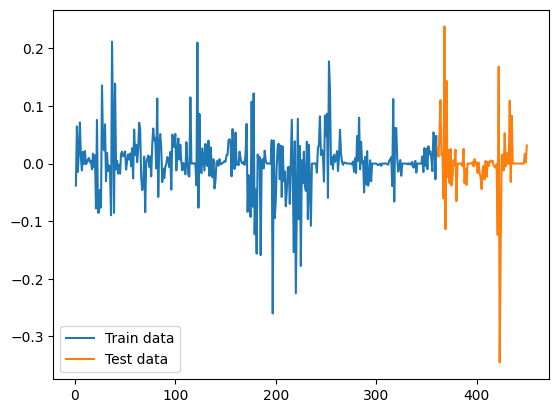

In [47]:
#Spltting the data into train and test sets

plt.figure()
plt.plot(classic_train_df["Delta"], label="Train data")
plt.plot(classic_test_df["Delta"], label="Test data")
plt.legend()
plt.show()

We create an ARMA model (in reality ARIMA as the series was already differentiated), using a class built on our own.

In [48]:
# Initiate the ARMA class

LineaTimeSeriesModel = linear_time_series.LineaTimeSeriesModel(classic_train_df["Delta"])

In [49]:
# Selecting the last relevant lags

ma_max_order = LineaTimeSeriesModel.get_ma_max_order()
ar_max_order = LineaTimeSeriesModel.get_ar_max_order()
print(f"Max MA order: {ma_max_order}, Max AR order: {ar_max_order}")

Max MA order: 2, Max AR order: 3


In [50]:
# Selecting the best model according to AIC using the maximum relevant lags

warnings.filterwarnings("ignore")

selected_models = LineaTimeSeriesModel.select_model(ma_max_order, ar_max_order)
selected_models["aic"]

The p-value of the L-JungBox test is 0.0010769501074859085 for the model ARIMA(0,0,0) with AIC = -865.2753020188441
The p-value of the L-JungBox test is 0.00019603097391850257 for the model ARIMA(1,0,0) with AIC = -868.6999244134302
The p-value of the L-JungBox test is 0.16297763069657353 for the model ARIMA(2,0,0) with AIC = -876.2575485804443
The p-value of the L-JungBox test is 0.7157039287487104 for the model ARIMA(3,0,0) with AIC = -880.290798166852
The p-value of the L-JungBox test is 0.00035552134315067045 for the model ARIMA(0,0,1) with AIC = -867.1486027223268
The p-value of the L-JungBox test is 0.000996118074009808 for the model ARIMA(1,0,1) with AIC = -869.6690742834808
The p-value of the L-JungBox test is 0.9172372412594008 for the model ARIMA(2,0,1) with AIC = -883.1324185428401
The p-value of the L-JungBox test is 0.9436762578020534 for the model ARIMA(3,0,1) with AIC = -881.5935715246574
The p-value of the L-JungBox test is 0.28029800957465645 for the model ARIMA(0,0,2)

{'order': (2, 0, 1),
 'model': <statsmodels.tsa.arima.model.ARIMAResultsWrapper at 0x1ba926a31d0>,
 'aic': np.float64(-883.1324185428401)}

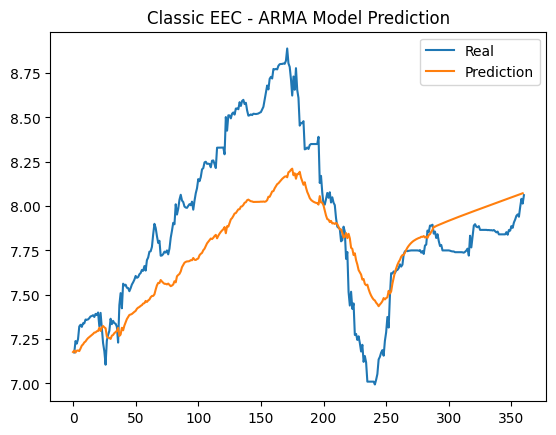

In [51]:
# Prediction using our model
train_pred, test_pred = LineaTimeSeriesModel.model_prediction(selected_models["aic"]["model"])
prediction = np.concatenate([train_pred, test_pred])

# Cumulative sum to get back to the original scale
cum_train_pred = np.cumsum(train_pred) + classic_df["SPOT"].iloc[0]
cum_test_pred = np.cumsum(test_pred) + cum_train_pred.iloc[-1]
cum_prediction = np.cumsum(prediction) + classic_df["SPOT"].iloc[0]

plt.figure()
plt.title("Classic EEC - ARMA Model Prediction")
plt.plot(classic_train_df["SPOT"], label="Real")
plt.plot(cum_prediction, label="Prediction")
plt.legend()
plt.show()

In [52]:
# Asssessing performances of ARIMA model
arima_model_metrics = tools.model_metrics(LineaTimeSeriesModel.train_dependent, cum_train_pred, LineaTimeSeriesModel.test_dependent, cum_test_pred)

all_metrics = arima_model_metrics.get_all_metrics()
all_metrics

{'train': {'mae': 7.713470145971037,
  'rmse': 7.717456448645649,
  'mape': inf,
  'r2': -20745.296219818112},
 'test': {'mae': nan, 'rmse': 7.976731219354144, 'mape': nan, 'r2': 1.0}}

### RNN

#### GRU

Parameters to optimize :

-   Lookback : Number of points used to predict the next oneNombre de points utilisés pour prédire le point suivant
-   Hidden size : Number of GRU cells per layer
-   Number of layers : Number of layers


*NB : After having conducted many tests 1 layer seems to provide better results than 2 layers*

In [53]:
# Initializing the GRU class
GRU = gated_reccurent_unit.GRU(classic_df["Normalized Spot"], train_test_ratio=0.8)

##### Tuning Training Parameters

In [54]:
train_param_grid = {
    "l2" : [1e-02, 1e-03, 1e-04, 1e-05, 1e-06],
    "lrs" : [1, 0.1, 0.01, 0.001],
    "epochs" : [20, 30, 40, 60, 80, 100, 120, 140],
    "epochs_mid" : 80,
    "patience": 10,
    "min_delta": 1e-4,
    "n_splits": 5,
    "val_size": 200,
    "min_train_size" : 50     
}

model_param = {
    "lookback": 40,
    "hidden_size": 16,
    "num_layers": 1,
}
GRU.tune_train(train_param_grid, model_param)

GRU.training_params

Training results: cv_mse : 0.020553607493638992, val_size : 200, n_splits : 5


{'lr': 0.1, 'l2': 1e-06, 'epochs': 60}

##### Tuning Model Parameters

In [55]:
model_param_grid = {
    "lookback": [int(x) for x in np.linspace(10, 70, 12)],
    "hidden_size": [2, 4, 8, 16],
    "num_layers": [1, 2],
}
GRU.tune_model(model_param_grid)

lookback=10, hidden=2, layers=1 → MSE=0.000860
lookback=10, hidden=2, layers=2 → MSE=0.001132
lookback=10, hidden=4, layers=1 → MSE=0.000772
lookback=10, hidden=4, layers=2 → MSE=0.000839
lookback=10, hidden=8, layers=1 → MSE=0.000787
lookback=10, hidden=8, layers=2 → MSE=0.000780
lookback=10, hidden=16, layers=1 → MSE=0.001456
lookback=10, hidden=16, layers=2 → MSE=0.004196
lookback=15, hidden=2, layers=1 → MSE=0.001157
lookback=15, hidden=2, layers=2 → MSE=0.004210
lookback=15, hidden=4, layers=1 → MSE=0.000822
lookback=15, hidden=4, layers=2 → MSE=0.001606
lookback=15, hidden=8, layers=1 → MSE=0.001328
lookback=15, hidden=8, layers=2 → MSE=0.002033
lookback=15, hidden=16, layers=1 → MSE=0.000829
lookback=15, hidden=16, layers=2 → MSE=0.000917
lookback=20, hidden=2, layers=1 → MSE=0.000998
lookback=20, hidden=2, layers=2 → MSE=0.001256
lookback=20, hidden=4, layers=1 → MSE=0.000945
lookback=20, hidden=4, layers=2 → MSE=0.001790
lookback=20, hidden=8, layers=1 → MSE=0.000860
lookback=

In [57]:
data_type = "train"
y_pred, y = GRU.predict(data=data_type)

y_pred, y = minmax_scaler.inverse_transform(y_pred.reshape(-1,1)), minmax_scaler.inverse_transform(y.reshape(-1,1))

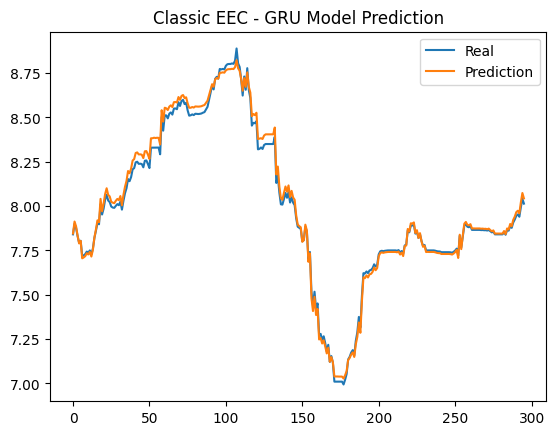

In [58]:
plt.figure()
plt.title("Classic EEC - GRU Model Prediction")
plt.plot(y, label="Real")
plt.plot(y_pred, label="Prediction")
plt.legend()
plt.show()

#### LSTM